In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

from astropy import coordinates as coordinates
from astropy import units as u
from astropy.time import Time


from skyfield.api import load, wgs84

In [2]:
# Build a timescale for SkyField calculations
#ts = load.timescale(builtin=False) #https://maia.usno.navy.mil/ser7/finals2000A.daily.extended
ts = load.timescale(builtin=True)

# Load TLEs for geostationary satellites visible from Rubin
EUTELSAT_117W_A = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=39122&FORMAT=TLE' 
EUTELSAT_117W_B = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=41589&FORMAT=TLE' #Part of GPS/WAAS
GOES_16 = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=41866&FORMAT=TLE'
STARONE_C3 = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=38991&FORMAT=TLE'
ASCENT = 'https://celestrak.org/NORAD/elements/gp.php?CATNR=51287&FORMAT=TLE'

# Live loading
#eutel_sat_a = load.tle_file(EUTELSAT_117W_A, reload=True, filename='eutel_sat_a.txt')[0]
#eutel_sat_b = load.tle_file(EUTELSAT_117W_B, reload=True, filename='eutel_sat_b.txt')[0]
#goes_16 = load.tle_file(GOES_16, reload=True, filename='goes_16.txt')[0]
#starone_c3 = load.tle_file(STARONE_C3, reload=True, filename='star-one.txt')[0]
#ascent = load.tle_file(ASCENT, reload=True, filename='ascent.txt')[0]

# Preloaded
eutel_sat_a = load.tle_file(EUTELSAT_117W_A, reload=False, filename='/Users/walter/TLE/sat_a-2024-04-23.txt')[0]
eutel_sat_b = load.tle_file(EUTELSAT_117W_B, reload=False, filename='/Users/walter/TLE/sat_b-2024-04-23.txt')[0]
##goes_16 = load.tle_file(GOES_16, reload=False, filename='/Users/walter/TLE/goes-2024-04-22.txt')[0]
##goes_16 = load.tle_file(GOES_16, reload=False, filename='/Users/walter/TLE/goes-2024-04-23.txt')[0]
goes_16 = load.tle_file(GOES_16, reload=False, filename='/Users/walter/TLE/new-TLE.txt')[0]
starone_c3 = load.tle_file(STARONE_C3, reload=False, filename='/Users/walter/star-one-23.txt')[0]
ascent = load.tle_file(ASCENT, reload=False, filename='/Users/walter/ascent-23.txt')[0]


In [3]:
# Check epoch of the satellites
print(f'{eutel_sat_a.name} last updated on \t {eutel_sat_a.epoch.utc_jpl()}')
print(f'{eutel_sat_b.name} last updated on \t {eutel_sat_b.epoch.utc_jpl()}')
print(f'{goes_16.name} last updated on \t\t {goes_16.epoch.utc_jpl()}')
print(f'{starone_c3.name} last updated on \t\t {starone_c3.epoch.utc_jpl()}')
print(f'{ascent.name} last updated on \t\t\t {ascent.epoch.utc_jpl()}')

EUTELSAT 117 WEST A last updated on 	 A.D. 2024-Apr-23 13:44:05.0914 UTC
EUTELSAT 117 WEST B last updated on 	 A.D. 2024-Apr-23 05:32:04.5459 UTC
GOES 16 last updated on 		 A.D. 2024-Apr-23 19:36:11.3671 UTC
STAR ONE C3 last updated on 		 A.D. 2024-Apr-23 12:43:58.9437 UTC
ASCENT last updated on 			 A.D. 2024-Apr-24 01:20:35.4901 UTC


In [4]:
# Set the location of the observatory 
rubin_obs = coordinates.EarthLocation.of_site('Rubin Observatory')
# la_serena = wgs84.latlon(-29.9045, -71.2489, 67.056)  # Alternative 

Rubin= wgs84.latlon(rubin_obs.lat.deg, rubin_obs.lon.deg, rubin_obs.height.value)

In [5]:
# Get the position of the satellites at a given time(s)

# Was 11 to 13
start_day = 23
end_day = 24

start = ts.utc(2024, 4, start_day, 23, 0, 0)
stop  = ts.utc(2024, 4, end_day,  23, 0, 0)    

time_array = ts.linspace(start, stop, (end_day - start_day)*2*24)

eutel_sat_a_position = eutel_sat_a.at(time_array)
eutel_sat_b_position = eutel_sat_b.at(time_array)
goes_16_position = goes_16.at(time_array)

wgs84.latlon_of(eutel_sat_b_position)

(<Angle 48 values from 00deg 00' 04.2" to 00deg 00' 02.2">,
 <Angle 48 values from -117deg 00' 45.8" to -117deg 00' 53.4">)

In [6]:
# Set the pressure and temperature to use for refraction
# Call .altaz() with no parameters to ignore the atmosphere.
# 
# The differences with and w/o atmosphere range from 40" to 100" for GOES-16
# and EUTELSAT 117W B respectively.  Trying to match the Stellarium atmosphere 
# achieves agreement within ~ 2" for EUTELSAT 117W B.

# Default skyfield Atmosphere
pressure, temp = 'standard', 'standard'

# To match Stellarium Atmosphere
pressure, temp = 1013.25, 15.0

In [7]:
# Calculate Alt,Az of satellites
eutel_a_alt, eutel_a_az, eutel_a_dist = (eutel_sat_a - Rubin).at(time_array).altaz()
eutel_b_alt, eutel_b_az, eutel_b_dist = (eutel_sat_b - Rubin).at(time_array).altaz()
goes_16_alt, goes_16_az, goes_16_dist = (goes_16 - Rubin).at(time_array).altaz()
ascent_alt, ascent_az, ascent_dist = (ascent - Rubin).at(time_array).altaz()

# Calculate RA, Dec of satellites
eutel_a_ra, eutel_a_dec, eutel_a_dist = (eutel_sat_a - Rubin).at(time_array).radec()
eutel_b_ra, eutel_b_dec, eutel_b_dist = (eutel_sat_b - Rubin).at(time_array).radec()
goes_16_ra, goes_16_dec, goes_16_dist = (goes_16 - Rubin).at(time_array).radec()
ascent_ra, ascent_dec, ascent_dist = (ascent - Rubin).at(time_array).radec()

In [8]:
# If things go out of range this message well tell us why
#eutel_sat_a_position.message

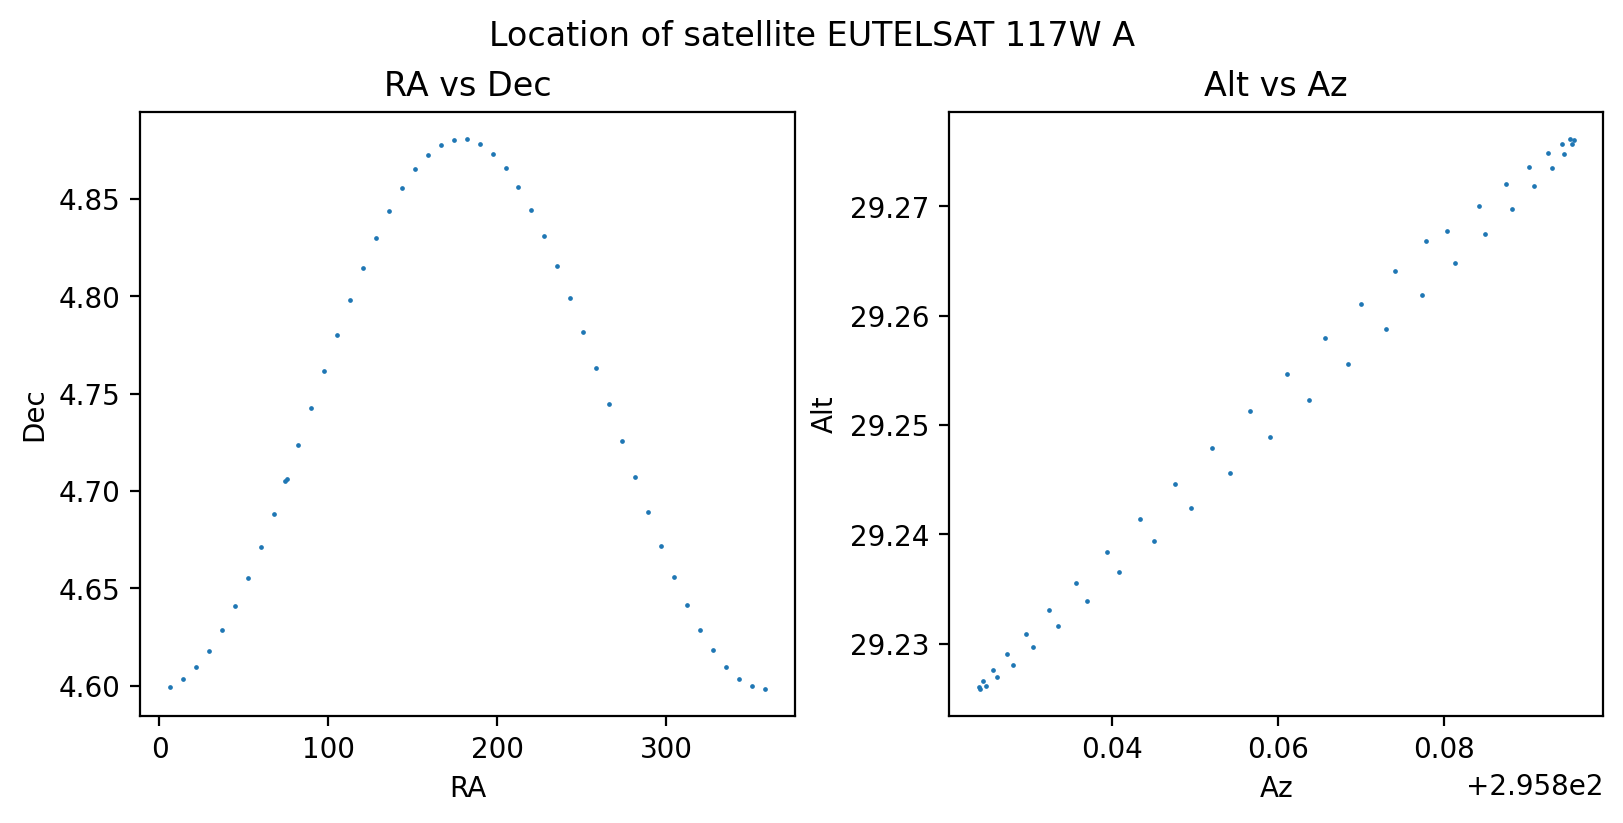

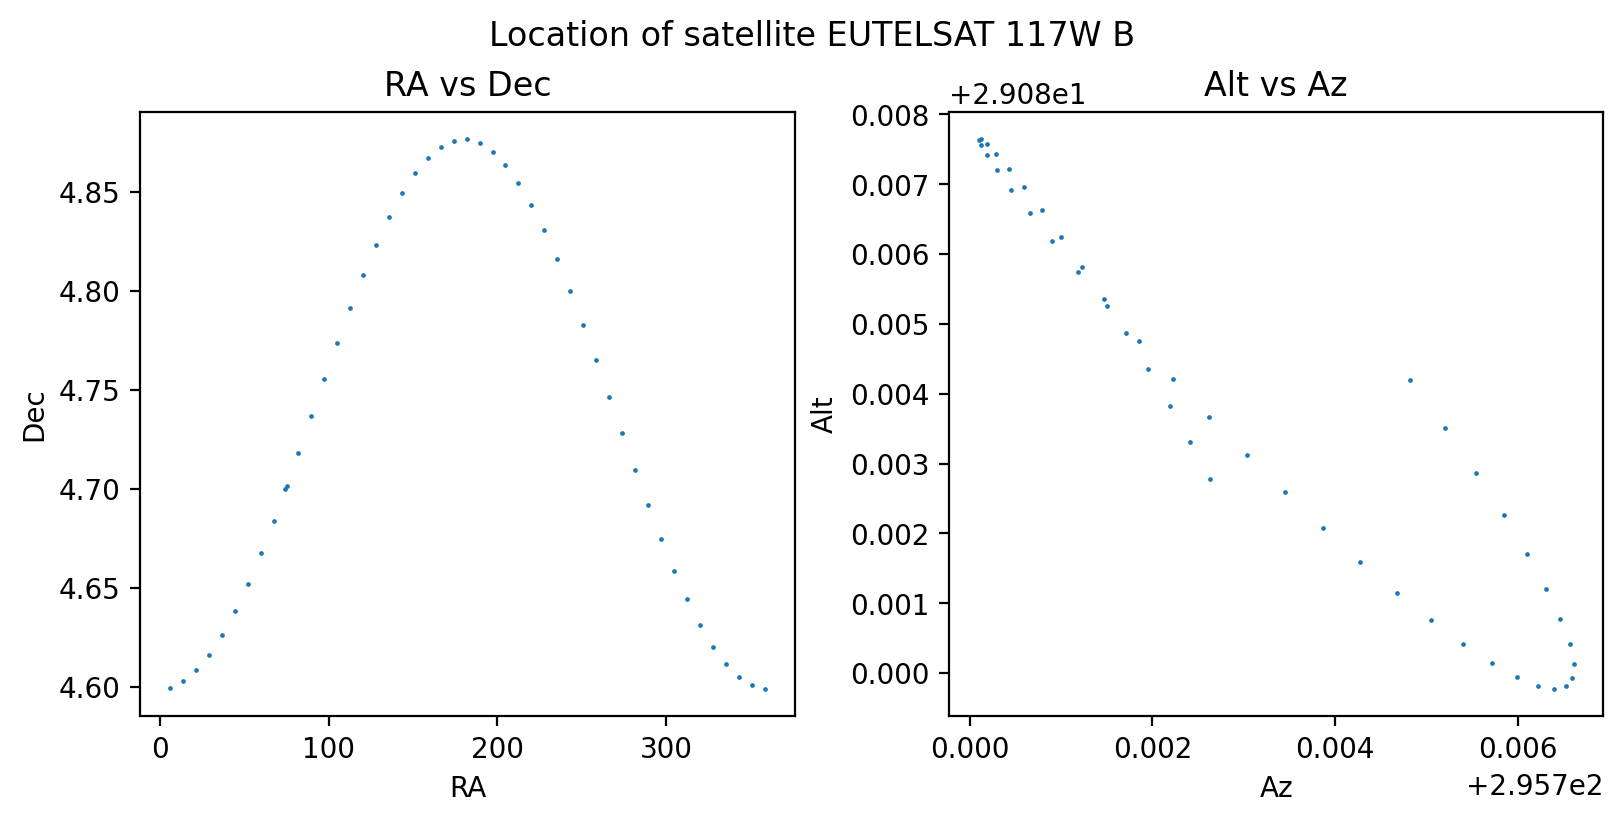

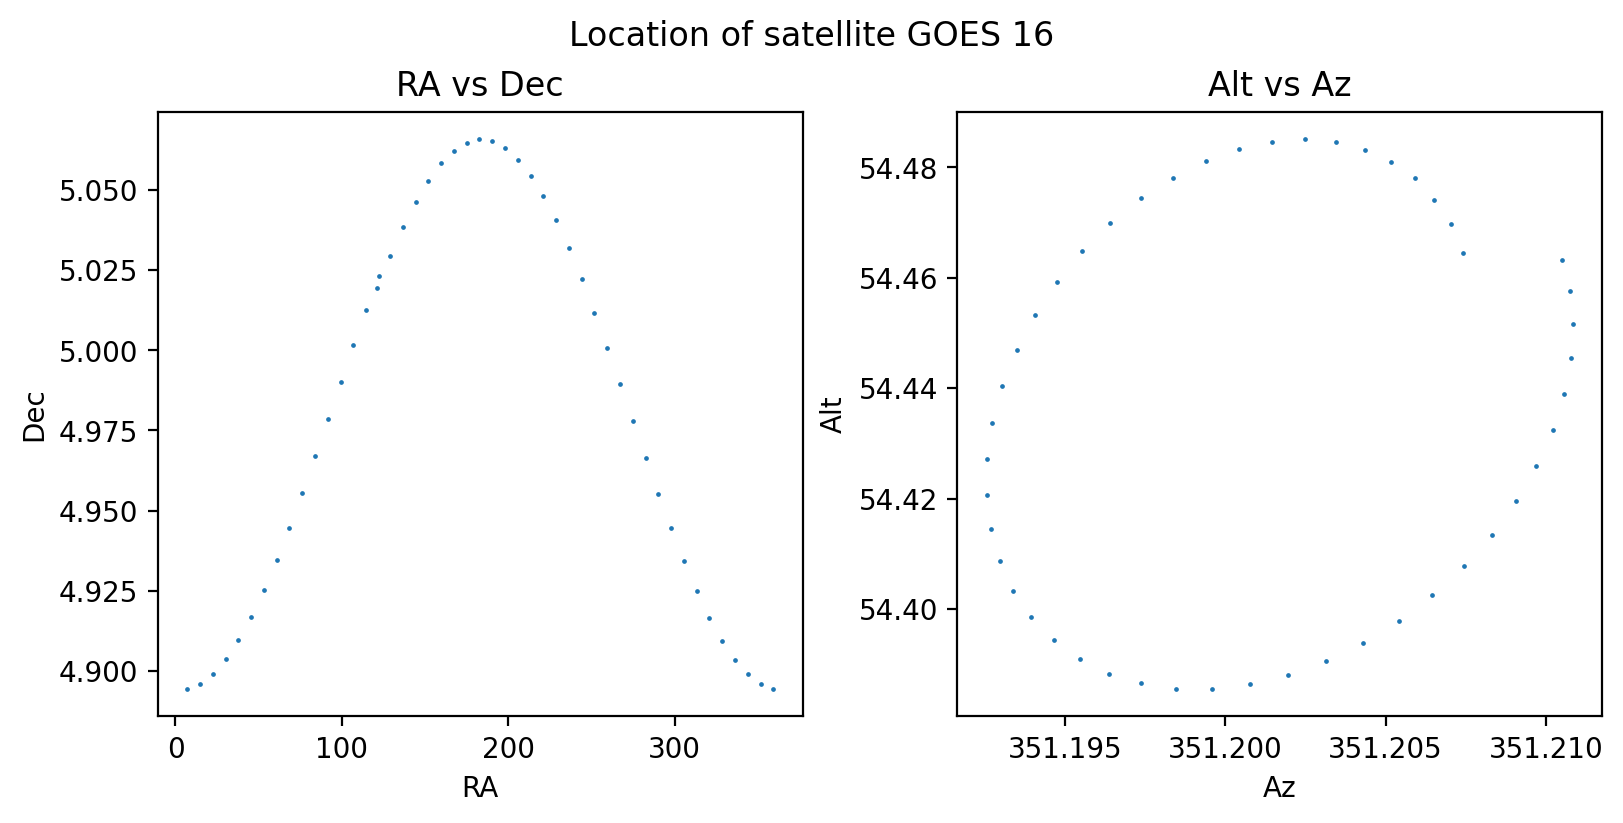

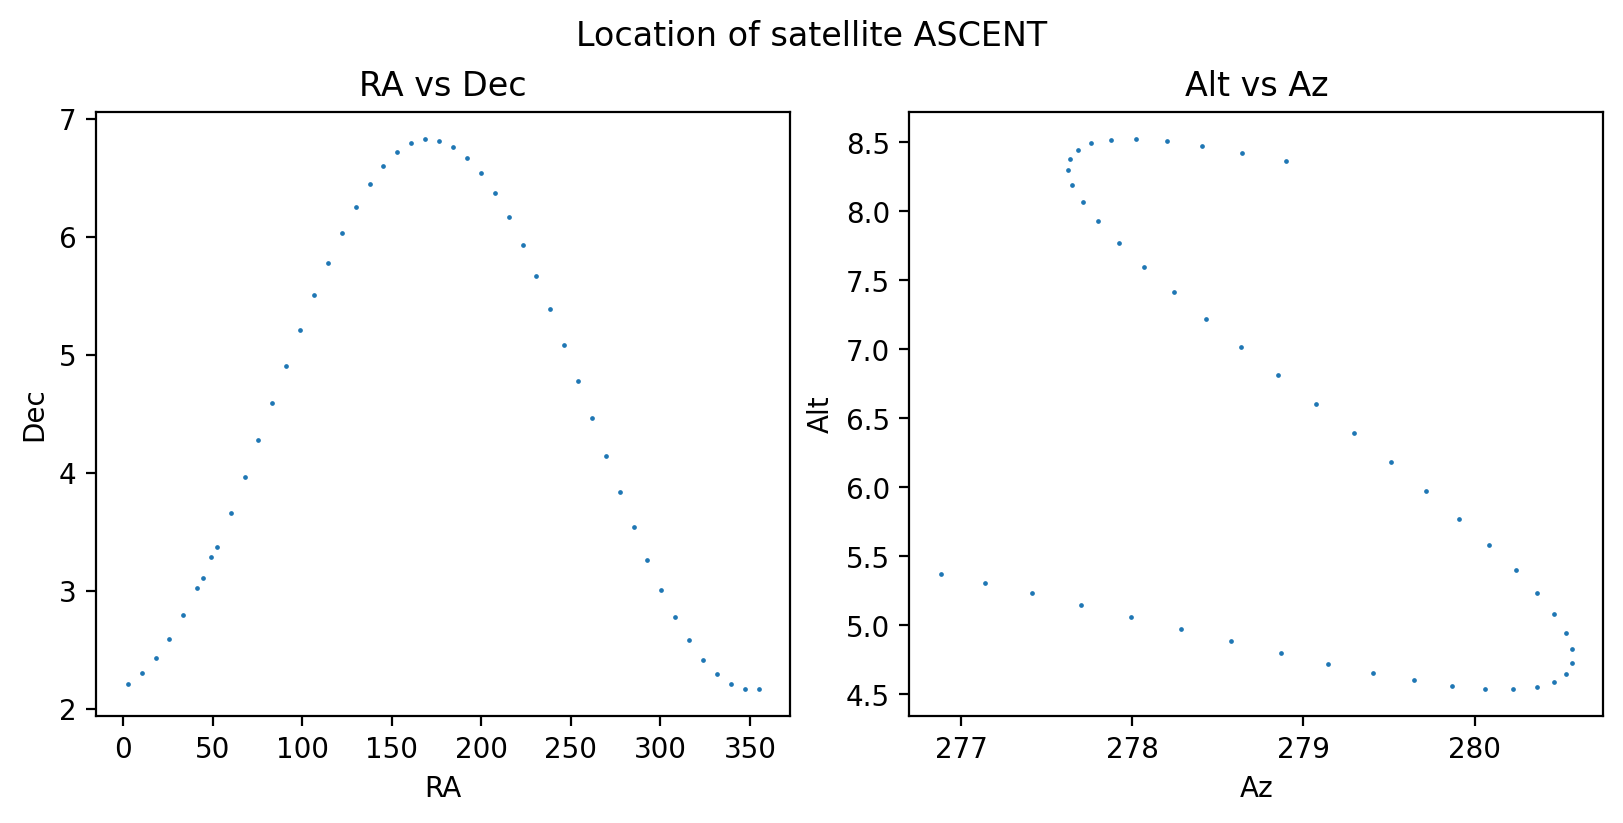

In [9]:
def plot_satellite(name, ra, dec, alt, az):
    fig, axes = plt.subplot_mosaic('AB', constrained_layout=True, figsize=(8,4))
    fig.suptitle(f'Location of satellite {name}')

    axes['A'].scatter(ra._degrees, dec.degrees, marker=".", s=2.0)
    axes['B'].scatter(az.degrees, alt.degrees, marker=".", s=2.0)

    axes['A'].set_title('RA vs Dec')
    axes['B'].set_title('Alt vs Az')

    axes['A'].set_xlabel('RA')
    axes['A'].set_ylabel('Dec')

    axes['B'].set_xlabel('Az')
    axes['B'].set_ylabel('Alt')

    #axes['B'].set_xticklabels(axes['B'].get_xticklabels(), rotation = 25)

plot_satellite('EUTELSAT 117W A', eutel_a_ra, eutel_a_dec, eutel_a_alt, eutel_a_az)
plot_satellite('EUTELSAT 117W B', eutel_b_ra, eutel_b_dec, eutel_b_alt, eutel_b_az)
plot_satellite('GOES 16', goes_16_ra, goes_16_dec, goes_16_alt, goes_16_az)
plot_satellite('ASCENT', ascent_ra, ascent_dec, ascent_alt, ascent_az)


In [10]:
# Put in specific time to Check

# time_check = ts.now()
# time_check = start

# On the 22nd

# time_check = ts.tai(2024, 4, 23, 1, 17, 20.902)  # 23 BEG

# On the 23rd

#time_check = ts.tai(2024, 4, 24, 0, 25, 53.701) # 06

time_check = ts.tai(2024, 4, 24, 0, 31, 5.190)  # 26 BEG
#time_check = ts.tai(2024, 4, 24, 0, 31, 11.420)  # 26 END

#time_check = ts.tai(2024, 4, 24, 0, 31, 14.430)   # 27 BEG
#time_check = ts.tai(2024, 4, 24, 0, 31, 20.692)   # 27 END

Azimuth: 295.8901 Altitude: 29.2736  Distance: 38665.90864538201 km


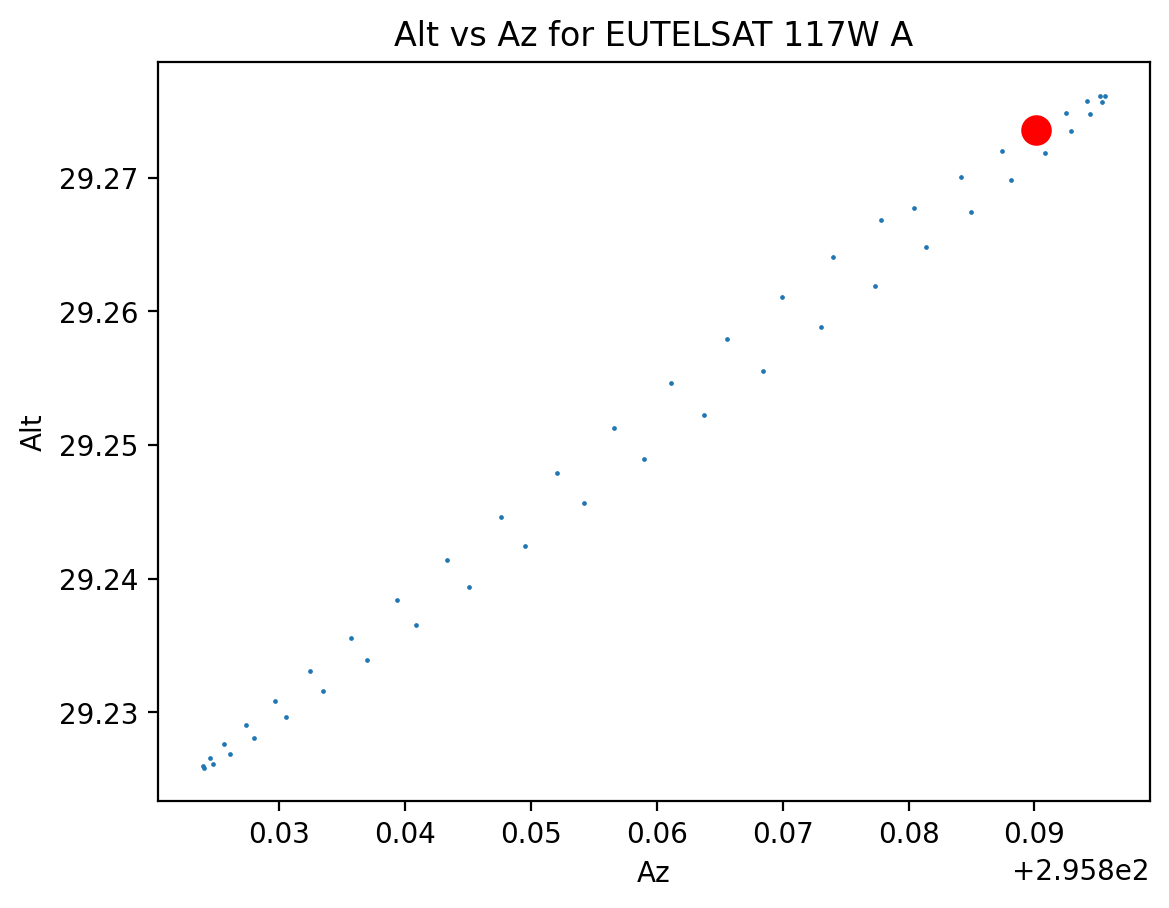

In [11]:
# Where is EutelSat 117A right now 
plt.scatter(eutel_a_az.degrees, eutel_a_alt.degrees, marker=".", s=2.0)

alt, az, dist = (eutel_sat_a - Rubin).at(time_check).altaz()
plt.plot(az.degrees, alt.degrees, marker='o', markersize=10, color='red')
plt.title('Alt vs Az for EUTELSAT 117W A')
plt.xlabel('Az')
plt.ylabel('Alt')

print(f'Azimuth: {az.degrees:1.4f} Altitude: {alt.degrees:1.4f}  Distance: {dist.km} km')

Azimuth: 351.2059 Altitude: 54.4778  Distance: 36802.62456039803 km


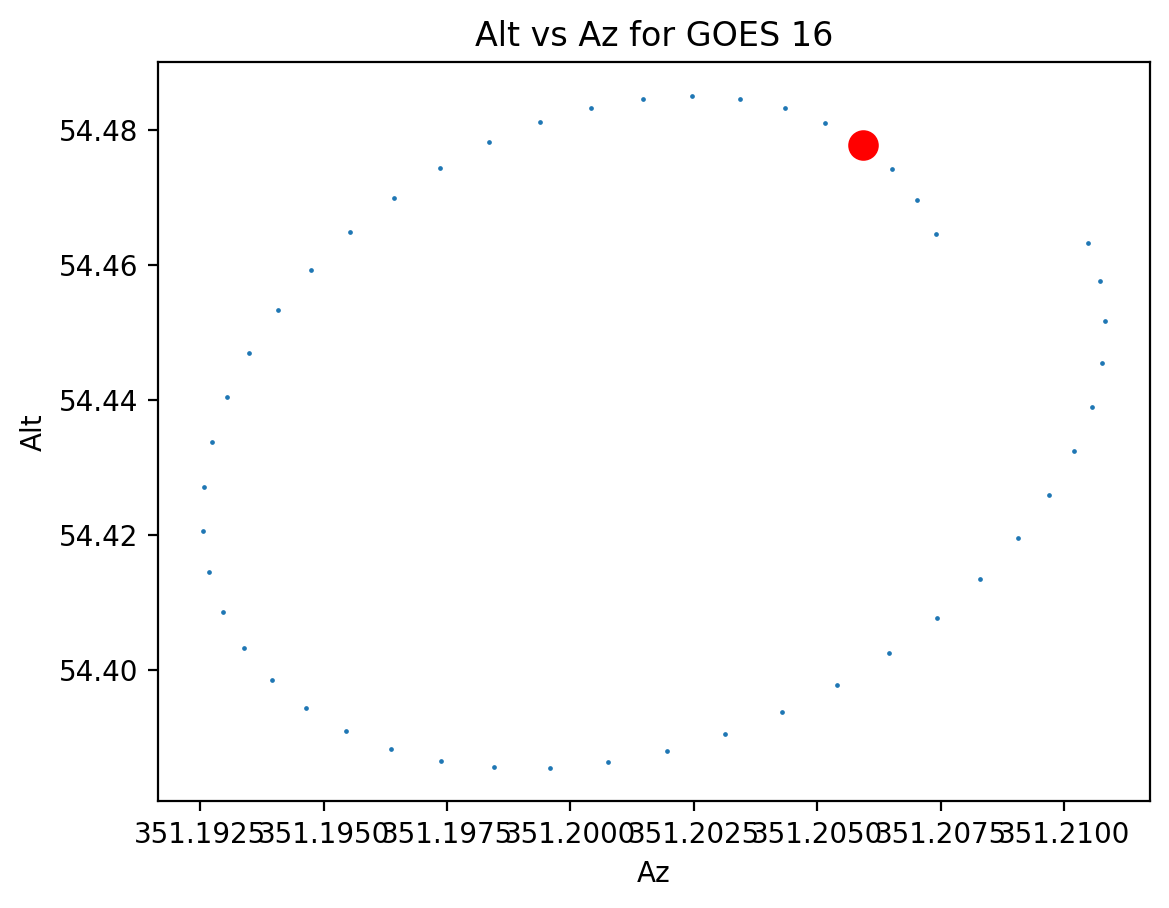

In [12]:
# Where is GOES-16 right now 
plt.scatter(goes_16_az.degrees, goes_16_alt.degrees, marker=".", s=2.0)

alt, az, dist = (goes_16 - Rubin).at(time_check).altaz()
plt.plot(az.degrees, alt.degrees, marker='o', markersize=10, color='red')
plt.title('Alt vs Az for GOES 16')
plt.xlabel('Az')
plt.ylabel('Alt')

print(f'Azimuth: {az.degrees:1.4f} Altitude: {alt.degrees:1.4f}  Distance: {dist.km} km')

Azimuth: 277.6855 Altitude: 5.1546  Distance: 40825.19049464959 km


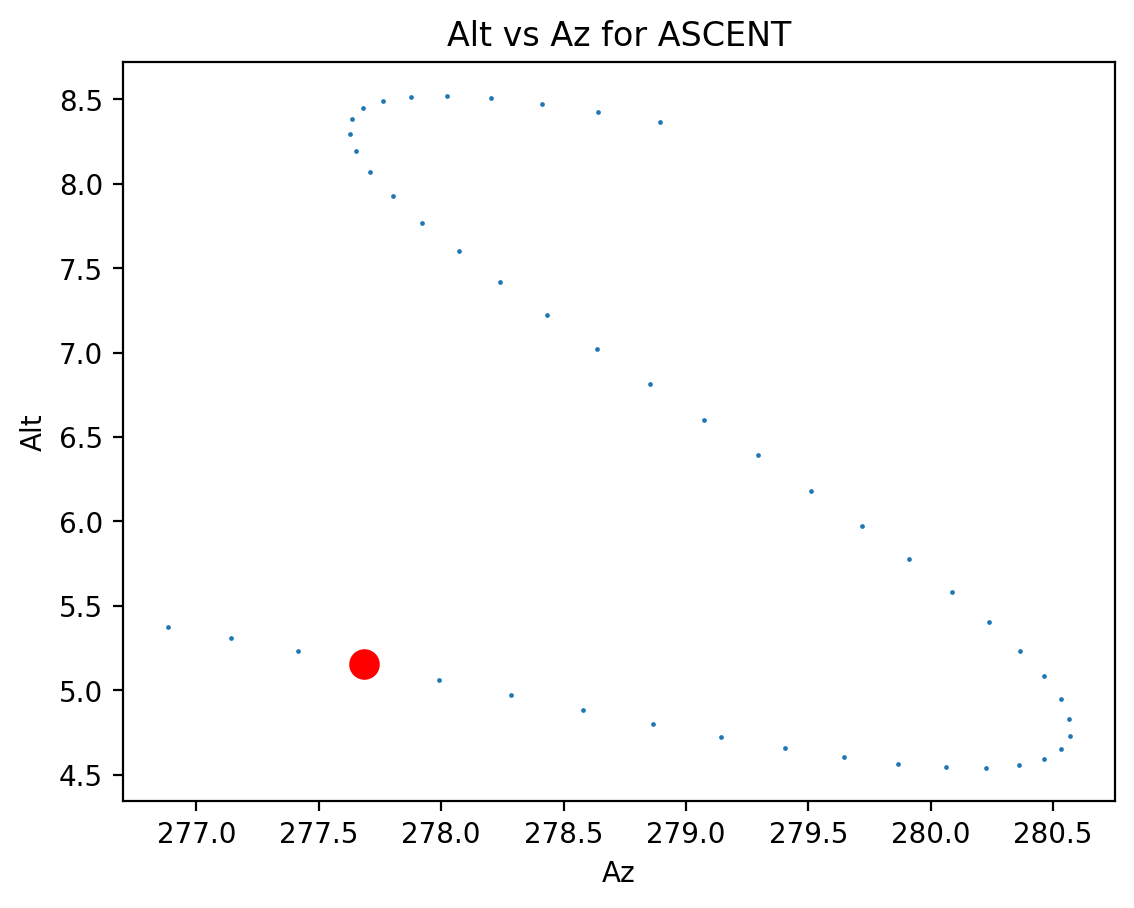

In [13]:
# Where is ASCENT right now 
plt.scatter(ascent_az.degrees, ascent_alt.degrees, marker=".", s=2.0)

alt, az, dist = (ascent - Rubin).at(time_check).altaz()
plt.plot(az.degrees, alt.degrees, marker='o', markersize=10, color='red')
plt.title('Alt vs Az for ASCENT')
plt.xlabel('Az')
plt.ylabel('Alt')

print(f'Azimuth: {az.degrees:1.4f} Altitude: {alt.degrees:1.4f}  Distance: {dist.km} km')

In [14]:
print(f'EUTELSAT_117W_A \t AZ Min:{eutel_a_az.degrees.min():4.3f} Max: {eutel_a_az.degrees.max():4.3f} \t Mean:{eutel_a_az.degrees.mean():4.3f}')
print(f'EUTELSAT_117W_A \t ALT Min:{eutel_a_alt.degrees.min():4.3f} Max: {eutel_a_alt.degrees.max():4.3f} \t Mean:{eutel_a_alt.degrees.mean():4.3f}')
print()

print(f'EUTELSAT_117W_B \t AZ Min:{eutel_b_az.degrees.min():4.3f} Max: {eutel_b_az.degrees.max():4.3f} \t Mean:{eutel_b_az.degrees.mean():4.3f}')
print(f'EUTELSAT_117W_B \t ALT Min:{eutel_b_alt.degrees.min():4.3f} Max: {eutel_b_alt.degrees.max():4.3f} \t Mean:{eutel_b_alt.degrees.mean():4.3f}')
print()

print(f'GOES_16 \t\t AZ  Min:{goes_16_az.degrees.min():4.3f} Max: {goes_16_az.degrees.max():4.3f} \t Mean:{goes_16_az.degrees.mean():4.3f}')
print(f'GOES_16 \t\t ALT Min:{goes_16_alt.degrees.min():4.3f} Max: {goes_16_alt.degrees.max():4.3f} \t Mean:{goes_16_alt.degrees.mean():4.3f}')


EUTELSAT_117W_A 	 AZ Min:295.824 Max: 295.896 	 Mean:295.860
EUTELSAT_117W_A 	 ALT Min:29.226 Max: 29.276 	 Mean:29.251

EUTELSAT_117W_B 	 AZ Min:295.700 Max: 295.707 	 Mean:295.703
EUTELSAT_117W_B 	 ALT Min:29.080 Max: 29.088 	 Mean:29.084

GOES_16 		 AZ  Min:351.193 Max: 351.211 	 Mean:351.201
GOES_16 		 ALT Min:54.386 Max: 54.485 	 Mean:54.436


In [15]:
# Satellite Position - Note manual text!

from astropy.coordinates import SkyCoord
import astropy.units as u

print('Location A:', (eutel_sat_a - Rubin).at(time_check).radec() )
print('Location B:', (eutel_sat_b - Rubin).at(time_check).radec() )
print('Location G:', (goes_16 - Rubin).at(time_check).radec() )

print( SkyCoord("06h 23m 57.11s", '+04deg 45m 29.2s',frame='icrs') )
print( SkyCoord("06h 22m 57.03s", '+04deg 45m 05.6s',frame='icrs') )
print( SkyCoord("09h 31m 18.18s", '+05deg 03m 19.2s',frame='icrs') )

Location A: (<Angle 06h 28m 32.45s>, <Angle +04deg 45' 39.3">, <Distance 0.000258466 au>)
Location B: (<Angle 06h 27m 32.27s>, <Angle +04deg 45' 15.6">, <Distance 0.000258625 au>)
Location G: (<Angle 09h 35m 53.15s>, <Angle +05deg 02' 44.9">, <Distance 0.00024601 au>)
<SkyCoord (ICRS): (ra, dec) in deg
    (95.98795833, 4.75811111)>
<SkyCoord (ICRS): (ra, dec) in deg
    (95.737625, 4.75155556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (142.82575, 5.05533333)>


In [16]:
#Satellite Location

print("*EUTEL A*")
print ((eutel_sat_a - Rubin).at(time_check).altaz()[1].degrees)
print ((eutel_sat_a - Rubin).at(time_check).altaz()[0].degrees)
#print()
print ((eutel_sat_a - Rubin).at(time_check).radec()[0]._degrees)
print ((eutel_sat_a - Rubin).at(time_check).radec()[1].degrees)

print("\n*EUTEL B*")
print ((eutel_sat_b - Rubin).at(time_check).altaz()[1].degrees)
print ((eutel_sat_b - Rubin).at(time_check).altaz()[0].degrees)
#print()
print ((eutel_sat_b - Rubin).at(time_check).radec()[0]._degrees)
print ((eutel_sat_b - Rubin).at(time_check).radec()[1].degrees)

print("\n*Goes 16*")
print ((goes_16 - Rubin).at(time_check).altaz()[1].degrees)
print ((goes_16 - Rubin).at(time_check).altaz()[0].degrees)
#print()
print ((goes_16 - Rubin).at(time_check).radec()[0]._degrees)
print ((goes_16 - Rubin).at(time_check).radec()[1].degrees)
print()

print("# 117A")
print(f'circle ({(eutel_sat_a - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(eutel_sat_a - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{EUTEL A}} color=yellow')

print("\n# 117B")
print(f'circle ({(eutel_sat_b - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(eutel_sat_b - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{EUTEL B}} color=yellow')

print("\n# GOES 16")
print(f'circle ({(goes_16 - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(goes_16 - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{GOES 16}} color=yellow')

print("\n# STARONE C3")
print(f'circle ({(starone_c3 - Rubin).at(time_check).radec()[0]._degrees:5.5f}, ' 
      f'{(starone_c3 - Rubin).at(time_check).radec()[1].degrees:5.5f}, .002) # text={{STARONE C3}} color=yellow')

*EUTEL A*
295.8901444902908
29.27357107140767
97.13519983895132
4.760924575754808

*EUTEL B*
295.7058283846833
29.082291350090657
96.88445130626461
4.754331084332372

*Goes 16*
351.2059319641052
54.4778151332991
143.97146179087662
5.045815780258268

# 117A
circle (97.13520, 4.76092, .002) # text={EUTEL A} color=yellow

# 117B
circle (96.88445, 4.75433, .002) # text={EUTEL B} color=yellow

# GOES 16
circle (143.97146, 5.04582, .002) # text={GOES 16} color=yellow

# STARONE C3
circle (144.20454, 5.07342, .002) # text={STARONE C3} color=yellow


In [17]:
exp_time = Time('2024-04-24T00:31:05.190', scale='tai')
ts.from_astropy(exp_time).utc_iso()

'2024-04-24T00:30:28Z'